In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, os, logging, json, random, wandb, shap
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [2]:
path = '/data/jlai/ntups/csv/jet_faking_BDT_input_basic3.csv'
df = pd.read_csv(path)
df.describe()

,balance,VertexBDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,metsigres,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,mt,weights,label
count,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,-1.745489e+02,1.251438e-01,-1.663472e+03,-4.654471e+02,-1.848742e+02,4.027364e-01,2.738863e+00,-1.317202e+02,-1.313245e+02,-1.842713e+02,...,2.709180e+04,1.947991e+05,1.931356e+05,8.173447e+05,8.082155e+03,9.400769e+03,1.752871e+00,5.145135e+02,6.037499e-01,1.390112e-03
std,3.835393e+02,1.348625e-01,1.103691e+04,4.990919e+02,3.894295e+02,6.314438e-01,6.313107e-01,3.400961e+02,3.402509e+02,3.897176e+02,...,2.307818e+04,1.623949e+05,1.632818e+05,8.139494e+05,1.485037e+04,5.880428e+03,1.232225e+00,3.809920e+02,7.646898e+00,3.725829e-02
min,-9.990000e+02,-3.265468e-01,-1.712589e+05,-9.990000e+02,-9.990000e+02,0.000000e+00,1.167295e-02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,8.526343e+03,1.000000e+05,2.001940e+03,1.500329e+05,-9.990000e+02,0.000000e+00,0.000000e+00,1.000004e+02,-9.143369e+01,0.000000e+00
25%,9.546858e-01,8.068899e-03,0.000000e+00,-9.990000e+02,4.369926e-02,5.094965e-02,2.728096e+00,2.204334e-01,5.477069e-01,3.878704e-01,...,1.057160e+04,1.177408e+05,1.162434e+05,2.738635e+05,-9.990000e+02,4.993511e+03,1.000000e+00,2.392391e+02,1.026595e-04,0.000000e+00
50%,1.283851e+00,1.647640e-01,0.000000e+00,1.517193e-01,4.694079e-01,1.503438e-01,2.991172e+00,1.017702e+00,2.089735e+00,2.023582e+00,...,1.767059e+04,1.480967e+05,1.473863e+05,4.551331e+05,-9.990000e+02,8.329055e+03,2.000000e+00,3.804795e+02,1.174600e-02,0.000000e+00
75%,2.922425e+00,2.371679e-01,0.000000e+00,1.378248e+00,2.476912e+00,4.133940e-01,3.090613e+00,2.863652e+00,3.105098e+00,3.039348e+00,...,3.643209e+04,2.160463e+05,2.158321e+05,1.013744e+06,2.159741e+04,1.265224e+04,3.000000e+00,6.762628e+02,5.386639e-02,0.000000e+00
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141592e+00,...,6.173285e+06,1.470684e+08,1.470684e+08,1.490961e+08,5.999986e+04,1.022158e+05,4.000000e+00,7.007911e+03,1.221239e+04,1.000000e+00


In [8]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()

df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

# Define X (features) and y (labels)
# Vars_drop = ['weights', 'label', 'process']
X = df_ml_input.drop(Vars_drop, axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

Number of event with negative weights : 218306


,balance,VertexBDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_phterm_jetterm,ph_phi,jet_central_eta,jet_central_pt2,jetterm,metsig,metsigres,met_noJVT,softerm,n_jet_central,weights,label,ph_eta,ph_pt
count,2.712769e+06,3.299733e+06,3.299732e+06,1.759863e+06,2.685312e+06,3.299733e+06,2.859950e+06,3.299733e+06,2.712769e+06,1.759863e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,3.838187e+00,1.251438e-01,-1.663472e+03,1.408597e+00,1.404322e+00,4.027364e-01,2.100537e+00,-2.322857e-03,1.122273e-03,1.301373e+05,5.232991e+05,1.190690e+01,2.709180e+04,1.931356e+05,9.400769e+03,1.752871e+00,6.196378e-01,1.390112e-03,4.619389e+00,5.638744e-06
std,6.130255e+00,1.348625e-01,1.103691e+04,9.495103e-01,1.176454e+00,6.314438e-01,1.085866e+00,1.819052e+00,1.077024e+00,1.853047e+05,7.927709e+05,1.038910e+01,2.307818e+04,1.632818e+05,5.880428e+03,1.232225e+00,7.645627e+00,3.725829e-02,4.657088e+02,4.934680e-06
min,3.173358e-02,-3.265468e-01,-1.712589e+05,9.537907e-07,1.192093e-07,0.000000e+00,0.000000e+00,-3.141592e+00,-2.499994e+00,2.000003e+04,0.000000e+00,2.269695e-01,8.526343e+03,2.001940e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.966429e-01,1.995369e-07
25%,1.127429e+00,8.068899e-03,0.000000e+00,5.465004e-01,1.804473e-01,5.094965e-02,1.077754e+00,-1.578759e+00,-7.428238e-01,3.167094e+04,3.469025e+04,3.802686e+00,1.057160e+04,1.162434e+05,4.993511e+03,1.000000e+00,1.428430e-03,0.000000e+00,7.511125e-01,1.213521e-06
50%,1.535997e+00,1.647640e-01,0.000000e+00,1.263772e+00,1.257375e+00,1.503438e-01,2.536042e+00,-6.129133e-03,-1.606467e-03,6.061452e+04,1.292316e+05,1.024574e+01,1.767059e+04,1.473863e+05,8.329055e+03,2.000000e+00,1.519263e-02,0.000000e+00,1.271312e+00,4.487454e-06
75%,3.771265e+00,2.371679e-01,0.000000e+00,2.256267e+00,2.651747e+00,4.133940e-01,3.115461e+00,1.571243e+00,7.461343e-01,1.416852e+05,6.824688e+05,1.590387e+01,3.643209e+04,2.158321e+05,1.265224e+04,3.000000e+00,6.219316e-02,0.000000e+00,2.644231e+00,8.563076e-06
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141584e+00,2.499999e+00,3.397636e+06,5.019984e+06,2.823775e+02,6.173285e+06,1.470684e+08,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00,8.314374e+05,1.999992e-05


Number of nan in each variable: 
balance                  586964
VertexBDTScore                0
dmet                          1
dphi_jj                 1539870
dphi_met_central_jet     614421
dphi_met_phterm               0
dphi_phterm_jetterm      439783
ph_phi                        0
jet_central_eta          586964
jet_central_pt2         1539870
jetterm                       0
metsig                        0
metsigres                     0
met_noJVT                     0
softerm                       0
n_jet_central                 0
weights                       0
label                         0
process                       0
ph_eta                        0
ph_pt                         0
dtype: int64
random number:  43


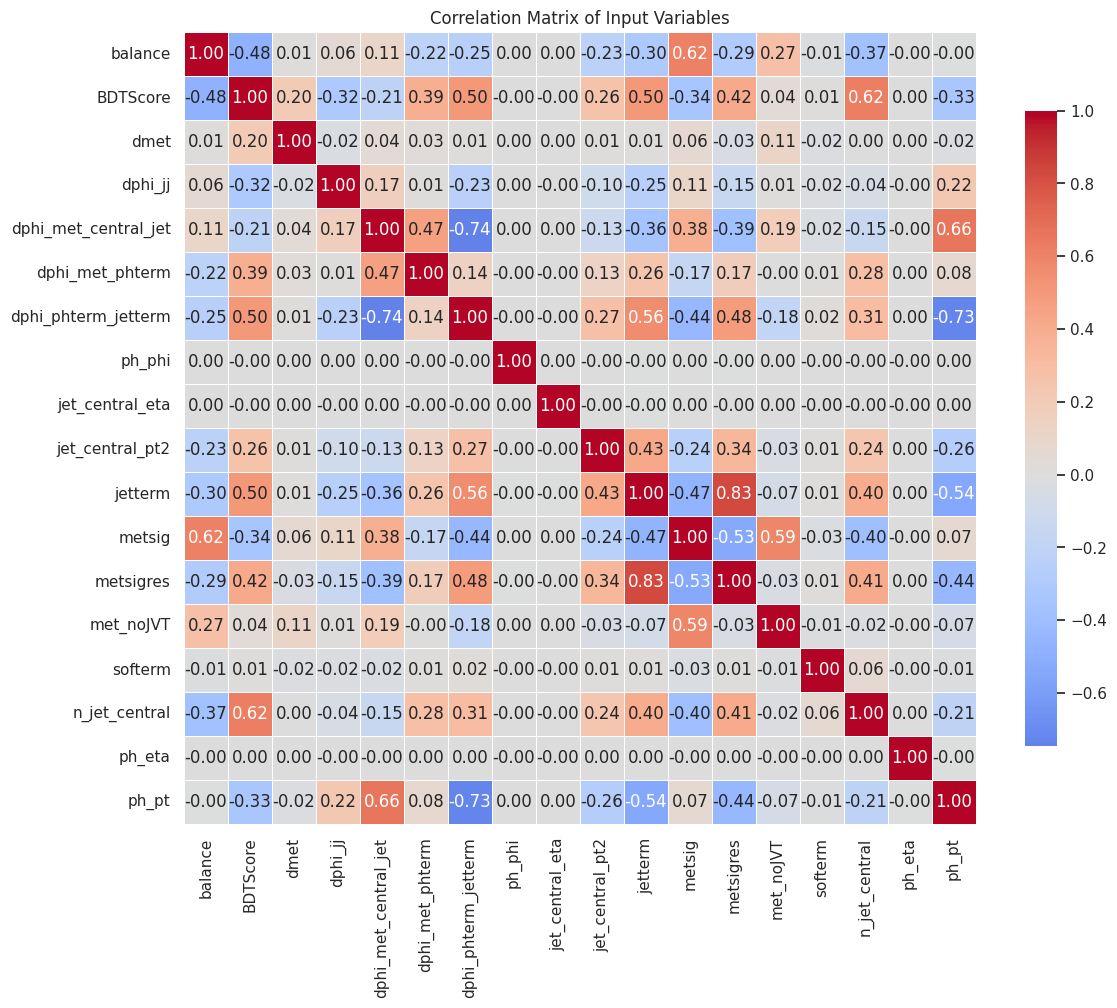

In [4]:
corr_features = df_ml_input.drop(Vars_drop, axis=1)
corr_matrix = corr_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Input Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()

In [9]:
# === Sweep Config ===
sweep_config = {
    "method": "random", # "bayes" or "random"
    "metric": {"name": "Test ROC AUC", "goal": "maximize"},
    "parameters": {
        "max_depth": {"min": 3, "max": 10, "distribution": "int_uniform"},
        "learning_rate": {"min": 0.0001, "max": 0.1},
        "n_estimators": {"min": 100, "max": 900, "distribution": "int_uniform"},
        "subsample": {"min": 0.2, "max": 0.8},
        "gamma": {"min": 0.1, "max": 1.0}
    }
}
def compute_significance(df, score_column="bdtscore", cut=0.01):
    sig = df[(df["label"] == 1) & (df[score_column] >= cut)]["weights"].sum()
    bkg = df[(df["label"] == 0) & (df[score_column] >= cut)]["weights"].sum()
    return sig / np.sqrt(bkg) if bkg > 0 else 0, sig/df[(df["label"] == 1)]["weights"].sum()

def sweep_train():
    with wandb.init() as run:
        config = run.config

        model = XGBClassifier(
            tree_method='hist',
            device='cuda',
            max_depth=config.max_depth,
            learning_rate=config.learning_rate,
            n_estimators=config.n_estimators,
            subsample=config.subsample,
            gamma=config.gamma,
            early_stopping_rounds=10,
            eval_metric=['logloss', 'error', 'auc'],
            missing=np.nan,
            random_state=random_num
        )

        model.fit(
            X_train, y_train,
            sample_weight=sw_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            sample_weight_eval_set=[sw_train, sw_test],
            verbose=False
        )

        y_test_pred = model.predict_proba(X_test.to_numpy())[:, 1]
        test_auc = roc_auc_score(y_test, y_test_pred, sample_weight=sw_test)

        df_tmp = df_ml_input.copy()
        df_tmp["bdtscore2"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]

        best_significance = 0
        best_acceptance = 0
        best_cut = 0
        for cut in np.arange(0, 0.15, 0.01):
            sig, acc = compute_significance(df_tmp, score_column="bdtscore2", cut=cut)
            if sig > best_significance:
                best_significance = sig
                best_acceptance = acc
                best_cut = cut

        wandb.log({
            "Test ROC AUC": test_auc,
            "Max S/sqrt(B)": best_significance,
            "Acceptance": best_acceptance,
            "bdtscore2 cut": best_cut
        })

        results = model.evals_result()
        train_loss = results['validation_0']['logloss']
        test_loss = results['validation_1']['logloss']

        for i, (train_l, test_l) in enumerate(zip(train_loss, test_loss)):
            wandb.log({
                "train_logloss": train_l,
                "test_logloss": test_l,
                "iteration": i
            })

In [10]:
# === Run Sweep ===
sweep_id = wandb.sweep(sweep_config, project="Dark_ph_BDT_Sweep")
wandb.agent(sweep_id, function=sweep_train, count=30)

Create sweep with ID: 4roma3zu
Sweep URL: https://wandb.ai/dlai211/Dark_ph_BDT_Sweep/sweeps/4roma3zu


wandb: Agent Starting Run: ir7s30o9 with config:
wandb: 	gamma: 0.7295231194016211
wandb: 	learning_rate: 0.016440533666955068
wandb: 	max_depth: 9
wandb: 	n_estimators: 522
wandb: 	subsample: 0.4118730288268229
wandb: Currently logged in as: dlai211 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[04:11:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
test_logloss,█▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.40818
Max S/sqrt(B),3.56287
Test ROC AUC,0.97587
bdtscore2 cut,0.03


wandb: Agent Starting Run: 4p451twz with config:
wandb: 	gamma: 0.5110263956745352
wandb: 	learning_rate: 0.08567303173385153
wandb: 	max_depth: 10
wandb: 	n_estimators: 387
wandb: 	subsample: 0.25465289661410395


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test_logloss,█▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▅▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.39771
Max S/sqrt(B),4.07372
Test ROC AUC,0.98178
bdtscore2 cut,0.04


wandb: Agent Starting Run: xleyg4sy with config:
wandb: 	gamma: 0.7297429379229654
wandb: 	learning_rate: 0.05996951655518031
wandb: 	max_depth: 6
wandb: 	n_estimators: 526
wandb: 	subsample: 0.5849993734924908


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
test_logloss,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▆▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.37538
Max S/sqrt(B),3.69137
Test ROC AUC,0.98199
bdtscore2 cut,0.04


wandb: Agent Starting Run: 3oq5m703 with config:
wandb: 	gamma: 0.5897098513453489
wandb: 	learning_rate: 0.062274621082789514
wandb: 	max_depth: 7
wandb: 	n_estimators: 108
wandb: 	subsample: 0.7542408854155553


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
test_logloss,█▇▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.39372
Max S/sqrt(B),3.35697
Test ROC AUC,0.9679
bdtscore2 cut,0.03


wandb: Agent Starting Run: jq9068k4 with config:
wandb: 	gamma: 0.11262448170718772
wandb: 	learning_rate: 0.0247712454377178
wandb: 	max_depth: 8
wandb: 	n_estimators: 563
wandb: 	subsample: 0.7105202078179467


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_logloss,█▇▅▅▅▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▇▇▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.41397
Max S/sqrt(B),3.49875
Test ROC AUC,0.9651
bdtscore2 cut,0.03


wandb: Agent Starting Run: a4f9tdc4 with config:
wandb: 	gamma: 0.41640495000600775
wandb: 	learning_rate: 0.03578432379574722
wandb: 	max_depth: 10
wandb: 	n_estimators: 121
wandb: 	subsample: 0.5152966244560816


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,██▇▇▇▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.40296
Max S/sqrt(B),3.52527
Test ROC AUC,0.93138
bdtscore2 cut,0.03


wandb: Agent Starting Run: arxarpy5 with config:
wandb: 	gamma: 0.6971110695107021
wandb: 	learning_rate: 0.09652394623143389
wandb: 	max_depth: 5
wandb: 	n_estimators: 394
wandb: 	subsample: 0.6706576862799946


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇███
test_logloss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▄▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.44125
Max S/sqrt(B),3.56671
Test ROC AUC,0.98192
bdtscore2 cut,0.03


wandb: Agent Starting Run: 44xplgn8 with config:
wandb: 	gamma: 0.14856410149796925
wandb: 	learning_rate: 0.027346262841852504
wandb: 	max_depth: 6
wandb: 	n_estimators: 407
wandb: 	subsample: 0.4424151975219636


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
test_logloss,██▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.37326
Max S/sqrt(B),3.2422
Test ROC AUC,0.95938
bdtscore2 cut,0.03


wandb: Agent Starting Run: ptbm4y5r with config:
wandb: 	gamma: 0.7545162530968177
wandb: 	learning_rate: 0.08407313779759155
wandb: 	max_depth: 10
wandb: 	n_estimators: 589
wandb: 	subsample: 0.4629394415337328


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇█████
test_logloss,█▆▆▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.2936
Max S/sqrt(B),3.9735
Test ROC AUC,0.9821
bdtscore2 cut,0.06


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 498l50io with config:
wandb: 	gamma: 0.8448439187245426
wandb: 	learning_rate: 0.005290983368683429
wandb: 	max_depth: 5
wandb: 	n_estimators: 164
wandb: 	subsample: 0.6399570631623249


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_logloss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_logloss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Acceptance,0.47028
Max S/sqrt(B),2.25866
Test ROC AUC,0.82204
bdtscore2 cut,0.1


wandb: Agent Starting Run: jls0vone with config:
wandb: 	gamma: 0.32484279275714967
wandb: 	learning_rate: 0.03408890146927908
wandb: 	max_depth: 3
wandb: 	n_estimators: 717
wandb: 	subsample: 0.598039089685586


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
test_logloss,█▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.40133
Max S/sqrt(B),3.37598
Test ROC AUC,0.98139
bdtscore2 cut,0.03


wandb: Agent Starting Run: y1iinxfs with config:
wandb: 	gamma: 0.9679131243570812
wandb: 	learning_rate: 0.021863316132388805
wandb: 	max_depth: 8
wandb: 	n_estimators: 196
wandb: 	subsample: 0.4629470608075296


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
test_logloss,█▇▇▇▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.35575
Max S/sqrt(B),3.23059
Test ROC AUC,0.92327
bdtscore2 cut,0.03


wandb: Agent Starting Run: r3bks91x with config:
wandb: 	gamma: 0.366039747745059
wandb: 	learning_rate: 0.0004352252607626844
wandb: 	max_depth: 6
wandb: 	n_estimators: 408
wandb: 	subsample: 0.32991012154031496


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_logloss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
train_logloss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
Acceptance,1
Max S/sqrt(B),0.32308
Test ROC AUC,0.8221
bdtscore2 cut,0


wandb: Agent Starting Run: 6nn6fr0n with config:
wandb: 	gamma: 0.6772043666193893
wandb: 	learning_rate: 0.08440446472968509
wandb: 	max_depth: 8
wandb: 	n_estimators: 522
wandb: 	subsample: 0.3697821764841173


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇▇▇█
test_logloss,█▆▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.33295
Max S/sqrt(B),3.87435
Test ROC AUC,0.98216
bdtscore2 cut,0.05


wandb: Agent Starting Run: 2dm0gp8j with config:
wandb: 	gamma: 0.3965881012219671
wandb: 	learning_rate: 0.008137192833182282
wandb: 	max_depth: 4
wandb: 	n_estimators: 599
wandb: 	subsample: 0.6594182463275438


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_logloss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Acceptance,0.23058
Max S/sqrt(B),2.18751
Test ROC AUC,0.87996
bdtscore2 cut,0.1


wandb: Agent Starting Run: 26hvbqz0 with config:
wandb: 	gamma: 0.26134736419093796
wandb: 	learning_rate: 0.06108946089372827
wandb: 	max_depth: 5
wandb: 	n_estimators: 413
wandb: 	subsample: 0.7631680787621375


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
test_logloss,█▇▆▆▅▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.4621
Max S/sqrt(B),3.75862
Test ROC AUC,0.9825
bdtscore2 cut,0.03


wandb: Agent Starting Run: hv2i38aq with config:
wandb: 	gamma: 0.6214407837243945
wandb: 	learning_rate: 0.08982796818062108
wandb: 	max_depth: 4
wandb: 	n_estimators: 665
wandb: 	subsample: 0.39348391835361335


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
test_logloss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.42235
Max S/sqrt(B),3.50788
Test ROC AUC,0.98184
bdtscore2 cut,0.03


wandb: Agent Starting Run: o78vex5w with config:
wandb: 	gamma: 0.3604796001217553
wandb: 	learning_rate: 0.03251267387161683
wandb: 	max_depth: 4
wandb: 	n_estimators: 524
wandb: 	subsample: 0.77488839995751


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
test_logloss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.41672
Max S/sqrt(B),3.42759
Test ROC AUC,0.98188
bdtscore2 cut,0.03


wandb: Agent Starting Run: piumbfht with config:
wandb: 	gamma: 0.1365443885218716
wandb: 	learning_rate: 0.08074826561211794
wandb: 	max_depth: 4
wandb: 	n_estimators: 711
wandb: 	subsample: 0.7927418019103043


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
test_logloss,█▆▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.44708
Max S/sqrt(B),3.67394
Test ROC AUC,0.98211
bdtscore2 cut,0.03


wandb: Agent Starting Run: ux1rkz6v with config:
wandb: 	gamma: 0.7220525381164177
wandb: 	learning_rate: 0.001238284417465457
wandb: 	max_depth: 5
wandb: 	n_estimators: 110
wandb: 	subsample: 0.41129836526517727


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
test_logloss,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_logloss,████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Acceptance,1
Max S/sqrt(B),0.32308
Test ROC AUC,0.82222
bdtscore2 cut,0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4z181ur4 with config:
wandb: 	gamma: 0.19362103676957032
wandb: 	learning_rate: 0.0974573422907678
wandb: 	max_depth: 7
wandb: 	n_estimators: 863
wandb: 	subsample: 0.20185111469613093


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██████
test_logloss,█▇▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.21262
Max S/sqrt(B),3.79057
Test ROC AUC,0.98075
bdtscore2 cut,0.08


wandb: Agent Starting Run: 78oy0c6v with config:
wandb: 	gamma: 0.11387514681221096
wandb: 	learning_rate: 0.08024956287541685
wandb: 	max_depth: 6
wandb: 	n_estimators: 832
wandb: 	subsample: 0.40118943924770534


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
test_logloss,█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.37661
Max S/sqrt(B),3.7189
Test ROC AUC,0.98202
bdtscore2 cut,0.04


wandb: Agent Starting Run: uk16a58b with config:
wandb: 	gamma: 0.45709231701029984
wandb: 	learning_rate: 0.010855375027645954
wandb: 	max_depth: 10
wandb: 	n_estimators: 569
wandb: 	subsample: 0.6314330576148617


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_logloss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Acceptance,0.31509
Max S/sqrt(B),2.54946
Test ROC AUC,0.88055
bdtscore2 cut,0.09


wandb: Agent Starting Run: ndii7swh with config:
wandb: 	gamma: 0.3365626143932774
wandb: 	learning_rate: 0.0565465749146791
wandb: 	max_depth: 3
wandb: 	n_estimators: 544
wandb: 	subsample: 0.3893446159475963


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_logloss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.39079
Max S/sqrt(B),3.30272
Test ROC AUC,0.98105
bdtscore2 cut,0.03


wandb: Agent Starting Run: dgsxdgac with config:
wandb: 	gamma: 0.9663264392655284
wandb: 	learning_rate: 0.07606832815667852
wandb: 	max_depth: 5
wandb: 	n_estimators: 429
wandb: 	subsample: 0.5715896264403381


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇█████
test_logloss,█▇▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.4122
Max S/sqrt(B),3.39238
Test ROC AUC,0.98168
bdtscore2 cut,0.03


wandb: Agent Starting Run: c5kbymof with config:
wandb: 	gamma: 0.244994318972978
wandb: 	learning_rate: 0.08532882586130976
wandb: 	max_depth: 9
wandb: 	n_estimators: 675
wandb: 	subsample: 0.534277773177686


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test_logloss,█▇▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.21721
Max S/sqrt(B),5.14795
Test ROC AUC,0.98231
bdtscore2 cut,0.1


wandb: Agent Starting Run: 339li7y1 with config:
wandb: 	gamma: 0.7452387310105151
wandb: 	learning_rate: 0.09289171977860192
wandb: 	max_depth: 5
wandb: 	n_estimators: 284
wandb: 	subsample: 0.27762591352627064


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
test_logloss,█▇▇▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.38577
Max S/sqrt(B),3.27147
Test ROC AUC,0.97936
bdtscore2 cut,0.03


wandb: Agent Starting Run: 3f4fzaf9 with config:
wandb: 	gamma: 0.4156018180613925
wandb: 	learning_rate: 0.009053468088411102
wandb: 	max_depth: 7
wandb: 	n_estimators: 680
wandb: 	subsample: 0.5177318631558826


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test_logloss,███▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▆▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.38019
Max S/sqrt(B),3.31182
Test ROC AUC,0.96608
bdtscore2 cut,0.03


wandb: Agent Starting Run: q0cyyovw with config:
wandb: 	gamma: 0.22406635841461764
wandb: 	learning_rate: 0.03881143239240125
wandb: 	max_depth: 3
wandb: 	n_estimators: 739
wandb: 	subsample: 0.32486664711539165


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
test_logloss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▅▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.39589
Max S/sqrt(B),3.3413
Test ROC AUC,0.98052
bdtscore2 cut,0.03


wandb: Agent Starting Run: 64ebwxi1 with config:
wandb: 	gamma: 0.35851802110981656
wandb: 	learning_rate: 0.022101766879790947
wandb: 	max_depth: 7
wandb: 	n_estimators: 357
wandb: 	subsample: 0.7708128217358765


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
test_logloss,█▇▇▇▅▅▅▅▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.40975
Max S/sqrt(B),3.44836
Test ROC AUC,0.97551
bdtscore2 cut,0.03


In [32]:

# === Model with best parameters ===
model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    max_depth=10,
    learning_rate=0.08567,
    n_estimators=387,
    subsample=0.2547,
    gamma=0.511,
    early_stopping_rounds=10,
    eval_metric=['logloss', 'error', 'auc'],
    use_label_encoder=False,
    missing=np.nan
)

model.fit(
    X_train, y_train,
    sample_weight=sw_train,
    eval_set=[(X_test, y_test)],
    sample_weight_eval_set=[sw_test],
    verbose=True
)

# === Evaluation ===
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
Auc = roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
df_output = df_ml_input.copy()
df_output["MLBDTScore"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]
df["MLBDTScore"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]
print(f"Test ROC AUC: {Auc:.4f}")

# save the dataframe to csv file
# df.to_csv("/data/jlai/ntups/bdt_output/bdt_0mu.csv", index=False)

# save the model
# model.save_model("/data/jlai/ntups/bdt_output/bdt_0mu_model.json")

[0]	validation_0-logloss:0.11641	validation_0-error:0.00023	validation_0-auc:0.82375
[1]	validation_0-logloss:0.10636	validation_0-error:0.00023	validation_0-auc:0.82442
[2]	validation_0-logloss:0.09724	validation_0-error:0.00023	validation_0-auc:0.82460
[3]	validation_0-logloss:0.08894	validation_0-error:0.00023	validation_0-auc:0.84203
[4]	validation_0-logloss:0.08139	validation_0-error:0.00023	validation_0-auc:0.84203
[5]	validation_0-logloss:0.07452	validation_0-error:0.00023	validation_0-auc:0.84206
[6]	validation_0-logloss:0.06826	validation_0-error:0.00023	validation_0-auc:0.84204
[7]	validation_0-logloss:0.06255	validation_0-error:0.00023	validation_0-auc:0.84205
[8]	validation_0-logloss:0.05734	validation_0-error:0.00023	validation_0-auc:0.84205


[17:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[9]	validation_0-logloss:0.05258	validation_0-error:0.00023	validation_0-auc:0.84211
[10]	validation_0-logloss:0.04824	validation_0-error:0.00023	validation_0-auc:0.84203
[11]	validation_0-logloss:0.04428	validation_0-error:0.00023	validation_0-auc:0.84197
[12]	validation_0-logloss:0.04065	validation_0-error:0.00023	validation_0-auc:0.84221
[13]	validation_0-logloss:0.03734	validation_0-error:0.00023	validation_0-auc:0.84220
[14]	validation_0-logloss:0.03431	validation_0-error:0.00023	validation_0-auc:0.84219
[15]	validation_0-logloss:0.03154	validation_0-error:0.00023	validation_0-auc:0.84227
[16]	validation_0-logloss:0.02900	validation_0-error:0.00023	validation_0-auc:0.84228
[17]	validation_0-logloss:0.02668	validation_0-error:0.00023	validation_0-auc:0.84227
[18]	validation_0-logloss:0.02456	validation_0-error:0.00023	validation_0-auc:0.84236
[19]	validation_0-logloss:0.02261	validation_0-error:0.00023	validation_0-auc:0.84233
[20]	validation_0-logloss:0.02083	validation_0-error:0.

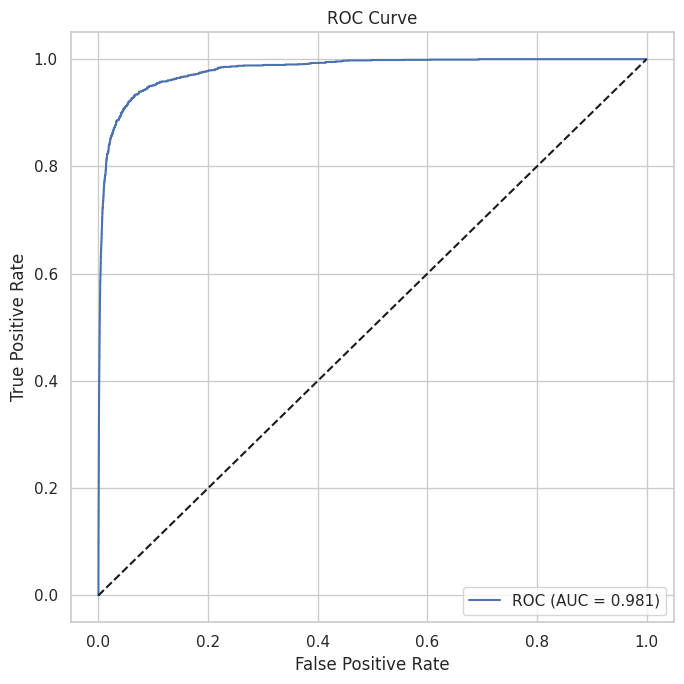

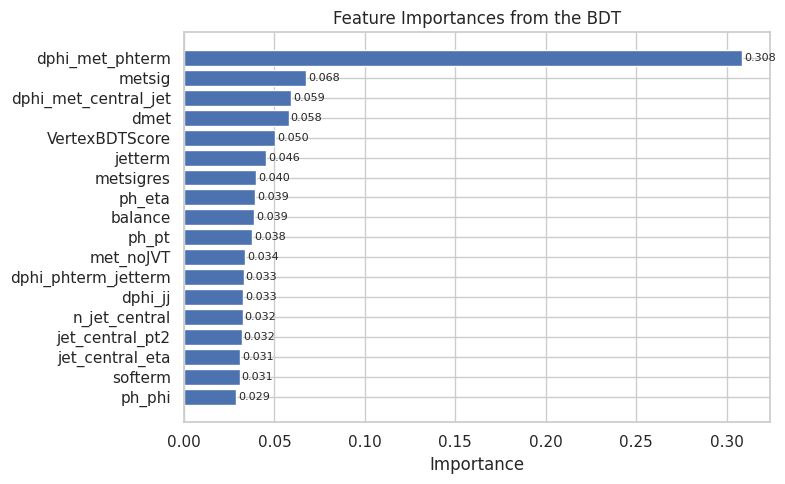

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig("roc_randomsearch.png")
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(Vars_drop, axis=1).columns

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(selected_columns)), importances[indices], align='center')

# Set y-ticks with feature names
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')

# Annotate each bar with the importance value
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=8)
plt.tight_layout()
# plt.savefig("feature_importance.png")
plt.show()

In [36]:
def compute_significance(df, cut=0.5):
    s = df[(df["label"] == 1) & (df["MLBDTScore"] >= cut)]["weights"].sum()
    b = df[(df["label"] == 0) & (df["MLBDTScore"] >= cut)]["weights"].sum()
    return s / np.sqrt(b) if b > 0 else 0, s/df[(df['label'] == 1)]['weights'].sum()

max_sig, acceptance = max(compute_significance(df_output, cut) for cut in np.arange(0.0, 0.15, 0.01))
print(f"Max S/√B: {max_sig:.3f}, Acceptance: {acceptance*100} %")

Max S/√B: 4.003, Acceptance: 38.11868675216264 %


In [13]:
ntuple_names = np.unique(df_output['process'])
for i in range(len(ntuple_names)):
    process = ntuple_names[i]
    df_tmp = df_output[df_output.process == process]
    df_tmp = df_tmp.replace(np.nan, -999)
    df_tmp = df_tmp[df_tmp.MLBDTScore > 0.04]
    print(process, sum(df_tmp['weights']))

Wgamma 789.6597103356083
Wjets 675.8530084242116
Zgamma 420.4914626049809
Zjets 1.4754961619473759
data23 41.703696516930236
gammajet_direct 5.8786821963088585
ggHyyd 176.07867482430558


Saved plot to significance_MLBDTScore_lowercut.png


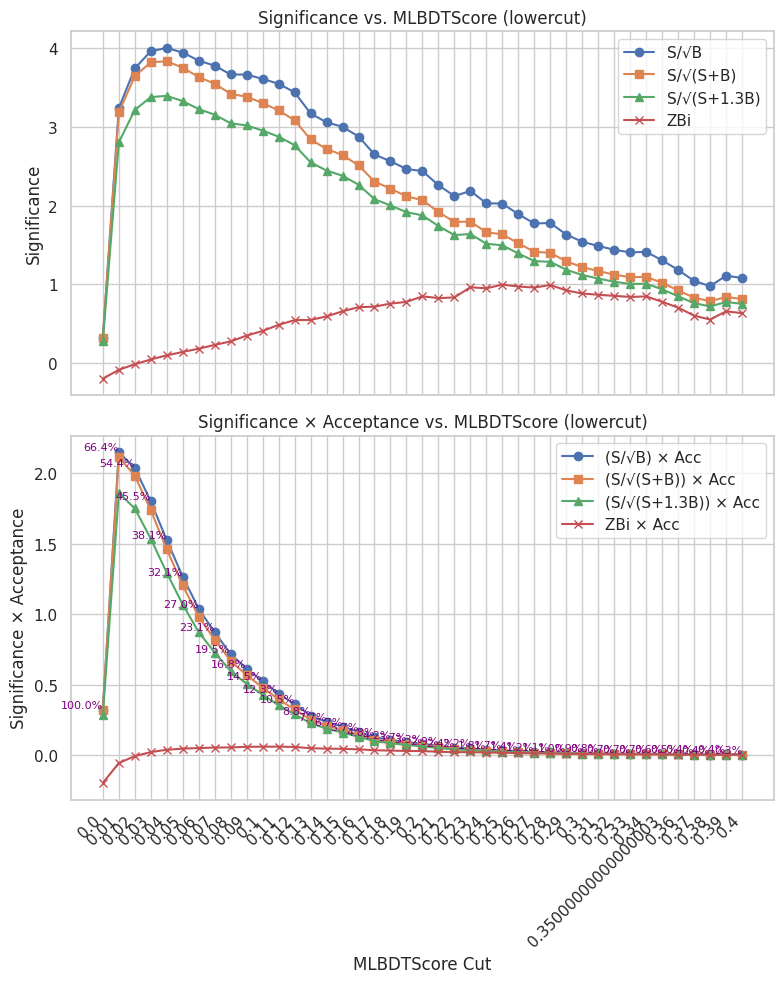

In [38]:
def binomial_significance(s, b):
    return s / np.sqrt(b) if b > 0 else 0

def s_over_sb(s, b):
    return s / np.sqrt(s + b) if (s + b) > 0 else 0

def s_over_s1p3b(s, b):
    return s / np.sqrt(s + 1.3 * b) if (s + 1.3 * b) > 0 else 0

def scan_significance(df, cut_var="MLBDTScore", cut_type="lowercut", cuts=np.arange(0, 0.71, 0.01)):
    sig_sqrtb = []
    sig_sqrt_sb = []
    sig_sqrt_s1p3b = []
    sig_zbi = []

    sigacc_sqrtb = []
    sigacc_sqrt_sb = []
    sigacc_sqrt_s1p3b = []
    sigacc_zbi = []

    acc_values = []

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cuts:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        s = sig_cut["weights"].sum()
        b = bkg_cut["weights"].sum()
        acceptance = s / total_sig_weight if total_sig_weight > 0 else 0

        # Compute significance
        sig1 = binomial_significance(s, b)
        sig2 = s_over_sb(s, b)
        sig3 = s_over_s1p3b(s, b)
        sig4 = zbi(s, b)

        sig_sqrtb.append(sig1)
        sig_sqrt_sb.append(sig2)
        sig_sqrt_s1p3b.append(sig3)
        sig_zbi.append(sig4)

        sigacc_sqrtb.append(sig1 * acceptance)
        sigacc_sqrt_sb.append(sig2 * acceptance)
        sigacc_sqrt_s1p3b.append(sig3 * acceptance)
        sigacc_zbi.append(sig4 * acceptance)

        acc_values.append(acceptance * 100)

    return cuts, acc_values, sig_sqrtb, sig_sqrt_sb, sig_sqrt_s1p3b, sig_zbi, \
           sigacc_sqrtb, sigacc_sqrt_sb, sigacc_sqrt_s1p3b, sigacc_zbi


def plot_significance(cuts, acc, sig1, sig2, sig3, sig4,
                      sigacc1, sigacc2, sigacc3, sigacc4,
                      cut_var, cut_type, save_path):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # Plot Significance
    ax1.plot(cuts, sig1, marker='o', label='S/√B')
    ax1.plot(cuts, sig2, marker='s', label='S/√(S+B)')
    ax1.plot(cuts, sig3, marker='^', label='S/√(S+1.3B)')
    ax1.plot(cuts, sig4, marker='x', label='ZBi')

    ax1.set_ylabel('Significance')
    ax1.set_title(f'Significance vs. {cut_var} ({cut_type})')
    ax1.grid(True)
    ax1.legend()

    # Plot Significance × Acceptance
    ax2.plot(cuts, sigacc1, marker='o', label='(S/√B) × Acc')
    ax2.plot(cuts, sigacc2, marker='s', label='(S/√(S+B)) × Acc')
    ax2.plot(cuts, sigacc3, marker='^', label='(S/√(S+1.3B)) × Acc')
    ax2.plot(cuts, sigacc4, marker='x', label='ZBi × Acc')

    for i, txt in enumerate(acc):
        ax2.text(cuts[i], sigacc1[i], f'{txt:.1f}%', fontsize=8, color='purple', ha='right', va='bottom')

    ax2.set_xlabel(f'{cut_var} Cut')
    ax2.set_ylabel('Significance × Acceptance')
    ax2.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticks(cuts)
    ax2.set_xticklabels(cuts, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()


cut_var = "MLBDTScore"
cut_type = "lowercut"
cut_values = np.arange(0, 0.4 + 3e-12, 0.01)

(cuts, acc, sig1, sig2, sig3, sig4,
 sigacc1, sigacc2, sigacc3, sigacc4) = scan_significance(df_output, cut_var, cut_type, cut_values)

plot_significance(
    cuts, acc, sig1, sig2, sig3, sig4,
    sigacc1, sigacc2, sigacc3, sigacc4,
    cut_var=cut_var,
    cut_type=cut_type,
    save_path=f"significance_{cut_var}_{cut_type}.png"
)


In [45]:
import numpy as np

def debug_one_var(
    var_name,
    signal_name='ggHyyd',
    pre_cut_var='MLBDTScore',
    pre_cut_thr=0.04,
    sigma_b_frac=0.3
):
    print("="*80)
    print(f"[DEBUG] Variable: {var_name} | Preselection: {pre_cut_var} >= {pre_cut_thr}")
    print("="*80)

    # Collect arrays per process
    bg_values, bg_weights, bg_labels = [], [], []
    sig_values, sig_weights = [], []
    all_proc_stats = []

    for process in ntuple_names:
        df_tmp = df[df.process == process]
        if pre_cut_var in df_tmp.columns:
            df_tmp = df_tmp[df_tmp[pre_cut_var] >= pre_cut_thr]

        if var_name not in df_tmp.columns:
            print(f"  [WARN] {var_name} not in dataframe for process {process}; skipping.")
            continue

        x = df_tmp[var_name].to_numpy()
        w = df_tmp['weights'].to_numpy()

        # Finite mask
        finite_mask = np.isfinite(x) & np.isfinite(w)
        n_nonfinite = x.size - finite_mask.sum()

        x = x[finite_mask].astype(np.float64, copy=False)
        w = w[finite_mask].astype(np.float64, copy=False)

        n_neg_w = (w < 0).sum()
        sum_w = w.sum()
        sum_w2 = (w**2).sum()
        x_min = np.nanmin(x) if x.size else np.nan
        x_max = np.nanmax(x) if x.size else np.nan

        all_proc_stats.append({
            "process": process,
            "n_events": x.size,
            "sum_w": float(sum_w),
            "sum_w2": float(sum_w2),
            "n_neg_w": int(n_neg_w),
            "n_nonfinite_dropped": int(n_nonfinite),
            "x_min": float(x_min) if np.isfinite(x_min) else x_min,
            "x_max": float(x_max) if np.isfinite(x_max) else x_max,
        })

        if process == signal_name:
            sig_values.append(x)
            sig_weights.append(w)
        else:
            bg_values.append(x)
            bg_weights.append(w)
            bg_labels.append(sample_dict.get(process, {}).get('legend', process))

    # Print per-process summary
    print("\n[Per-process stats after preselection & finite filtering]")
    for s in all_proc_stats:
        print(f"  {s['process']:>15} | n={s['n_events']:>7} | sum_w={s['sum_w']:>12.6g} "
              f"| sum_w2={s['sum_w2']:>12.6g} | neg_w={s['n_neg_w']:>6} "
              f"| nonfinite_dropped={s['n_nonfinite_dropped']:>4} "
              f"| x∈[{s['x_min']}, {s['x_max']}]")

    # Flatten
    sig_all = np.concatenate(sig_values) if sig_values else np.array([], dtype=np.float64)
    sig_wts = np.concatenate(sig_weights) if sig_weights else np.array([], dtype=np.float64)
    bg_all  = np.concatenate(bg_values)  if bg_values  else np.array([], dtype=np.float64)
    bg_wts  = np.concatenate(bg_weights) if bg_weights else np.array([], dtype=np.float64)

    print("\n[Merged stats]")
    print(f"  Signal: n={sig_all.size}, sum_w={sig_wts.sum():.6g}, neg_w={(sig_wts<0).sum()}")
    print(f"  Bkg   : n={bg_all.size}, sum_w={bg_wts.sum():.6g}, neg_w={(bg_wts<0).sum()}")

    # Load binning from your var config
    var_cfg = getVarDict(signal_name, signal_name, var_name=var_name)
    if var_name not in var_cfg:
        print(f"[ERROR] getVarDict did not return config for {var_name}. Got keys: {list(var_cfg.keys())}")
        return

    bins_cfg = var_cfg[var_name]['bins']
    # Robust bins: allow int or edges
    if np.isscalar(bins_cfg):
        if sig_all.size + bg_all.size:
            lo = np.nanmin(np.concatenate([sig_all, bg_all])) if (sig_all.size and bg_all.size) else (
                 np.nanmin(sig_all) if sig_all.size else np.nanmin(bg_all))
            hi = np.nanmax(np.concatenate([sig_all, bg_all])) if (sig_all.size and bg_all.size) else (
                 np.nanmax(sig_all) if sig_all.size else np.nanmax(bg_all))
            if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                lo, hi = 0.0, 1.0
        else:
            lo, hi = 0.0, 1.0
        bins = np.linspace(lo, hi, int(bins_cfg)+1)
    else:
        bins = np.asarray(bins_cfg, dtype=float)

    print("\n[Bin edges]")
    print(f"  nbins={len(bins)-1}, edges[0]={bins[0]}, edges[-1]={bins[-1]}")

    # Histograms
    S_counts, _ = np.histogram(sig_all, bins=bins, weights=sig_wts)
    B_counts, _ = np.histogram(bg_all,  bins=bins, weights=bg_wts)

    # Quick peek at first few bins
    show = min(10, len(S_counts))
    print("\n[First few bin contents]")
    for i in range(show):
        print(f"  bin {i:>3}: S={S_counts[i]:>12.6g} | B={B_counts[i]:>12.6g}")

    # Problematic bins
    idx_B_le0 = np.where(B_counts <= 0)[0]
    idx_SB_le0 = np.where(S_counts + B_counts <= 0)[0]
    idx_S1p3B_le0 = np.where(S_counts + 1.3*B_counts <= 0)[0]

    print("\n[Problematic bin indices]")
    print(f"  B<=0 bins          : {idx_B_le0.tolist()}")
    print(f"  S+B<=0 bins        : {idx_SB_le0.tolist()}")
    print(f"  S+1.3B<=0 bins     : {idx_S1p3B_le0.tolist()}")

    # Significance (safe)
    S_pos = np.clip(S_counts, 0.0, None)
    B_pos = np.clip(B_counts, 0.0, None)

    with np.errstate(divide='ignore', invalid='ignore'):
        sig_simple = np.where(B_pos > 0, S_pos/np.sqrt(B_pos), 0.0)
        sig_spb    = np.where(S_pos + B_pos > 0, S_pos/np.sqrt(S_pos + B_pos), 0.0)
        sig_s1p3b  = np.where(S_pos + 1.3*B_pos > 0, S_pos/np.sqrt(S_pos + 1.3*B_pos), 0.0)

    print("\n[Per-bin significance (first few)]")
    for i in range(show):
        print(f"  bin {i:>3}: S/√B={sig_simple[i]:>10.6g} | S/√(S+B)={sig_spb[i]:>10.6g} | S/√(S+1.3B)={sig_s1p3b[i]:>10.6g}")

    # Totals
    totS = float(np.nansum(S_pos))
    totB = float(np.nansum(B_pos))

    def safe_zbi(S, B, frac):
        try:
            return float(zbi(S, B, sigma_b_frac=frac))
        except Exception as e:
            print(f"  [WARN] zbi failed with S={S}, B={B}: {e}")
            return float("nan")

    tot_sig_sqrtB     = (totS/np.sqrt(totB))                  if totB > 0 else 0.0
    tot_sig_sqrtSB    = (totS/np.sqrt(totS + totB))           if (totS + totB) > 0 else 0.0
    tot_sig_sqrtS1p3B = (totS/np.sqrt(totS + 1.3*totB))       if (totS + 1.3*totB) > 0 else 0.0
    tot_zbi           = safe_zbi(totS, max(totB, 0.0), sigma_b_frac)

    print("\n[Totals]")
    print(f"  totS={totS:.6g}, totB={totB:.6g}")
    print(f"  S/√B={tot_sig_sqrtB:.6g} | S/√(S+B)={tot_sig_sqrtSB:.6g} | S/√(S+1.3B)={tot_sig_sqrtS1p3B:.6g} | ZBi={tot_zbi:.6g}")

    # ROC (only if both sides exist)
    if sig_all.size > 0 and bg_all.size > 0:
        y_true = np.concatenate([np.ones(sig_all.size, dtype=int), np.zeros(bg_all.size, dtype=int)])
        y_scores = np.concatenate([sig_all, bg_all])
        y_wts = np.concatenate([sig_wts, bg_wts])

        # Filter non-finite
        m = np.isfinite(y_scores) & np.isfinite(y_wts)
        y_true = y_true[m]; y_scores = y_scores[m]; y_wts = y_wts[m]

        try:
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_true, y_scores, sample_weight=y_wts)
            roc_auc = auc(fpr, tpr)
            print("\n[ROC]")
            print(f"  n_points={fpr.size}, AUC={roc_auc:.6g}, "
                  f"scores∈[{np.nanmin(y_scores):.6g}, {np.nanmax(y_scores):.6g}]")
        except Exception as e:
            print(f"  [WARN] ROC failed: {e}")
    else:
        print("\n[ROC] Skipped (empty signal or background after preselection).")

    # Log-scale feasibility (stacked background must be >0 per bin)
    can_log = (B_counts.size > 0) and np.all(np.isfinite(B_counts)) and np.all(B_counts > 0)
    print(f"\n[Log-scale OK?] {can_log} (requires all stacked B > 0)")
    print("="*80)

# ---- HOW TO RUN (example) ----
# debug_one_var("balance")     # replace with the variable that triggered warnings
debug_one_var("mt")

[DEBUG] Variable: mt | Preselection: MLBDTScore >= 0.04

[Per-process stats after preselection & finite filtering]
           Wgamma | n=   4321 | sum_w=     609.352 | sum_w2=     349.178 | neg_w=   391 | nonfinite_dropped=   0 | x∈[100.07932, 536.988]
            Wjets | n=   1462 | sum_w=     468.683 | sum_w2=     710.092 | neg_w=   177 | nonfinite_dropped=   0 | x∈[100.001015, 342.97833]
           Zgamma | n=   6614 | sum_w=     326.863 | sum_w2=     68.0212 | neg_w=   435 | nonfinite_dropped=   0 | x∈[100.01464, 629.2625]
            Zjets | n=     15 | sum_w=      1.4755 | sum_w2=    0.384216 | neg_w=     0 | nonfinite_dropped=   0 | x∈[100.43417, 136.46017]
           data23 | n=      4 | sum_w=     41.7037 | sum_w2=      437.27 | neg_w=     0 | nonfinite_dropped=   0 | x∈[100.79901, 131.10966]
  gammajet_direct | n=    164 | sum_w=     5.87868 | sum_w2=     15.9993 | neg_w=     0 | nonfinite_dropped=   0 | x∈[100.84532, 940.4442]
           ggHyyd | n=   1684 | sum_w=     176.0

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss

signal_name = 'ggHyyd'  # Define signal dataset
cut_name = 'bdt0mu'
corr_features = df.drop(Vars_drop, axis=1)

for cut_var_tmp in corr_features.columns:
# for cut_var_tmp in ['mt']:
    var_config = getVarDict(signal_name, 'ggHyyd', var_name=cut_var_tmp)
    
    for var in var_config:
        # print(var)
        bg_values = []     
        bg_weights = []    
        bg_colors = []     
        bg_labels = []     
    
        signal_values = [] 
        signal_weights = []
        signal_color = None 
        signal_label = None
    
        for j in range(len(ntuple_names)):
            process = ntuple_names[j]
            df_tmp = df[df.process == process]
            df_tmp = df_tmp[df_tmp.MLBDTScore >= 0.04]
            
            x = df_tmp[var]
            bins = var_config[var]['bins'] 
            # weights = df_tmp['weights']
            weights = abs(df_tmp['weights'])
            
            sample_info = sample_dict[process]
            color = sample_info['color']
            legend = sample_info['legend']
    
            
            if process == signal_name:  # signal
                signal_values.append(x)
                signal_weights.append(weights)
                signal_color = color
                signal_label = legend
            else:   # background
                bg_values.append(x)
                bg_weights.append(weights)
                bg_colors.append(color)
                bg_labels.append(legend)
    
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})
    
        ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                    label=bg_labels, stacked=True)
    
        ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                    label=signal_label, histtype='step', linewidth=2)
    
        signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
        signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])
    
        # Add error bar for signal (top plot)
        if len(signal_all) > 0:
            signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
            sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)
    
            ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                            color=signal_color, capsize=0)
    
        ax_top.set_yscale('log')
        ax_top.set_ylim(0.0001, 1e11)
        ax_top.set_xlim(bins[0], bins[-1])
        ax_top.minorticks_on()
        ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_top.set_ylabel("Events")
        ax_top.legend(ncol=2)
        # ax_top.set_title("vtx_sumPt distribution")
    
        bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
        bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])
    
        # Compute the weighted histogram counts using np.histogram
        S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     
    
        # Compute per-bin significance
        sig_simple = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)
    
        sqrt_B = np.sqrt(B_counts)
        sqrt_SplusB = np.sqrt(S_counts + B_counts)
        sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)
    
        # Avoid division by zero safely
        sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
        sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
        sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)
    
        # Add Binomial ExpZ per bin
        zbi_per_bin = np.array([
            zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
            for i in range(len(S_counts))
        ])
    
        # Compute the bin centers for plotting
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
        # Compute the total significance: total S / sqrt(total B)
        total_signal = np.sum(S_counts)
        total_bkg = np.sum(B_counts)
    
        if total_bkg > 0:
            total_sig_simple = total_signal / np.sqrt(total_bkg)
            total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
            total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
            total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
        else:
            total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0
    
        # --- Plot all significance curves ---
        ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                    label=f"S/√B = {total_sig_simple:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                    label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                    label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
        ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                    label=f"Binomial ExpZ = {total_sig_binomial:.4f}")
    
        ax_bot.set_xlabel(var_config[var]['title'])
        # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
        ax_bot.set_ylabel("Significance")
        ax_bot.set_ylim(-0.8, 2)
        ax_top.set_xlim(bins[0], bins[-1])
    
        # Do not set a title on the bottom plot.
        ax_bot.set_title("")
    
        # Draw a legend with purple text.
        leg = ax_bot.legend()
        for text in leg.get_texts():
            text.set_color('purple')
    
        plt.xlim(bins[0], bins[-1])
        plt.tight_layout()
        plt.savefig(f"/data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
        print(f"successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
        plt.close()
        # plt.show()
    
        y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
        # Use the vtx_sumPt values as the classifier output.
        y_scores = np.concatenate([signal_all, bg_all])
        # Combine the weights for all events.
        y_weights = np.concatenate([signal_weights_all, bg_weights_all])
    
        # Compute the weighted ROC curve.
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
        sorted_indices = np.argsort(fpr)
        fpr_sorted = fpr[sorted_indices]
        tpr_sorted = tpr[sorted_indices]
    
        roc_auc = auc(fpr_sorted, tpr_sorted)
    
        # Create a new figure for the ROC curve.
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {var}")
        plt.legend(loc="lower right")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()    
        plt.savefig(f"/data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
        print(f"successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
        plt.close()
        # plt.show()


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/balance_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_balance.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dmet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dmet.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_jj_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_jj.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_met_central_jet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_met_central_jet.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_met_phterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_met_phterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_met_ph_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_met_ph.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_met_jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_met_jetterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_phterm_jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_phterm_jetterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/dphi_ph_centraljet1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_dphi_ph_centraljet1.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/ph_pt_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_ph_pt.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/ph_eta_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_ph_eta.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/ph_phi_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_ph_phi.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/jet_central_eta_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_jet_central_eta.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/jet_central_pt1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_jet_central_pt1.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/jet_central_pt2_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_jet_central_pt2.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_jetterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/jetterm_sumet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_jetterm_sumet.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/metsig_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_metsig.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/metsigres_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_metsigres.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/met_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_met.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/met_noJVT_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_met_noJVT.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/metplusph_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_metplusph.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/failJVT_jet_pt1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_failJVT_jet_pt1.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/softerm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_softerm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/n_jet_central_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_n_jet_central.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/mt_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_bdt0mucut/roc_curve_mt.png
